In [2]:
# ============================================================================
# NOTEBOOK 2: MODEL TRAINING & EVALUATION (model_training.ipynb)
# ============================================================================

# Cell 1: Import Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, roc_curve, auc, 
                            classification_report, roc_auc_score)
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [4]:
# ============================================================================
# Cell 2: Load Data
# ============================================================================

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nMissing values in train:")
print(train.isnull().sum()[train.isnull().sum() > 0])

Train shape: (891, 12)
Test shape: (418, 11)

Missing values in train:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [5]:
# ============================================================================
# Cell 3: Feature Engineering
# ============================================================================

def feature_engineering(df, is_train=True):
    """
    Perform feature engineering on the dataset
    """
    df = df.copy()
    
    # 1. Handle Age missing values - Fill with median by Pclass and Sex
    df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    
    # 2. Handle Embarked missing values - Fill with mode
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # 3. Encode Sex: male=0, female=1
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # 4. Encode Embarked: S=0, C=1, Q=2
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # 5. Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # 6. Is alone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 7. Fare: Fill missing values with median
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # 8. Fare per person (if traveling with family)
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    
    # 9. Age groups
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 50, 100], 
                            labels=[0, 1, 2, 3, 4])
    
    # 10. Fare bins
    df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=[0, 1, 2, 3], duplicates='drop')
    
    # 11. Title from name (optional, but good feature)
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
    title_map = {
        'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3,
        'Dr': 4, 'Rev': 4, 'Col': 4, 'Major': 4,
        'Don': 5, 'Dona': 5, 'Mlle': 1, 'Ms': 1
    }
    df['Title'] = df['Title'].map(title_map).fillna(6)
    
    # 12. Child indicator
    df['IsChild'] = (df['Age'] < 18).astype(int)
    
    # Drop unnecessary columns
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    
    # Fill any remaining NaN values
    df = df.fillna(df.median(numeric_only=True))
    
    return df

# Apply feature engineering
train_fe = feature_engineering(train, is_train=True)
test_fe = feature_engineering(test, is_train=False)

print("\n" + "=" * 80)
print("FEATURES AFTER ENGINEERING")
print("=" * 80)
print("Train shape:", train_fe.shape)
print("Test shape:", test_fe.shape)
print("\nFeatures:", train_fe.columns.tolist())
print("\nData types:\n", train_fe.dtypes)


FEATURES AFTER ENGINEERING
Train shape: (891, 15)
Test shape: (418, 14)

Features: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'FarePerPerson', 'AgeGroup', 'FareBin', 'Title', 'IsChild']

Data types:
 Survived            int64
Pclass              int64
Sex                 int64
Age               float64
SibSp               int64
Parch               int64
Fare              float64
Embarked            int64
FamilySize          int64
IsAlone             int32
FarePerPerson     float64
AgeGroup         category
FareBin          category
Title             float64
IsChild             int32
dtype: object


In [6]:
# ============================================================================
# Cell 4: Prepare Train/Test Split
# ============================================================================

# Separate features and target
X = train_fe.drop('Survived', axis=1)
y = train_fe['Survived']

print("\nTarget distribution:")
print(y.value_counts())
print(f"Survival rate: {y.mean():.2%}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For tree-based models (no scaling needed)
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()


Target distribution:
Survived
0    549
1    342
Name: count, dtype: int64
Survival rate: 38.38%

Train set size: 712
Test set size: 179


In [7]:
# ============================================================================
# Cell 5: Model 1 - Logistic Regression
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 80)

lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"ROC-AUC: {lr_auc:.4f}")

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"Cross-Val Score: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std():.4f})")



MODEL 1: LOGISTIC REGRESSION
Accuracy: 0.8156
Precision: 0.7812
Recall: 0.7246
F1-Score: 0.7519
ROC-AUC: 0.8559
Cross-Val Score: 0.8034 (+/- 0.0264)


In [8]:
# ============================================================================
# Cell 6: Model 2 - Random Forest
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 2: RANDOM FOREST")
print("=" * 80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_tree, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_tree)
y_pred_proba_rf = rf_model.predict_proba(X_test_tree)[:, 1]

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_auc:.4f}")

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train_tree, y_train, cv=5)
print(f"Cross-Val Score: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")



MODEL 2: RANDOM FOREST
Accuracy: 0.8268
Precision: 0.7969
Recall: 0.7391
F1-Score: 0.7669
ROC-AUC: 0.8472
Cross-Val Score: 0.8231 (+/- 0.0163)


In [9]:
# ============================================================================
# Cell 7: Model 3 - Gradient Boosting
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3: GRADIENT BOOSTING")
print("=" * 80)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_tree, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_tree)
y_pred_proba_gb = gb_model.predict_proba(X_test_tree)[:, 1]

# Evaluation
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb)
gb_recall = recall_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb)
gb_auc = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Accuracy: {gb_accuracy:.4f}")
print(f"Precision: {gb_precision:.4f}")
print(f"Recall: {gb_recall:.4f}")
print(f"F1-Score: {gb_f1:.4f}")
print(f"ROC-AUC: {gb_auc:.4f}")

# Cross-validation
gb_cv_scores = cross_val_score(gb_model, X_train_tree, y_train, cv=5)
print(f"Cross-Val Score: {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std():.4f})")



MODEL 3: GRADIENT BOOSTING
Accuracy: 0.8156
Precision: 0.7812
Recall: 0.7246
F1-Score: 0.7519
ROC-AUC: 0.8428
Cross-Val Score: 0.8077 (+/- 0.0324)



MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.815642   0.781250 0.724638  0.751880 0.855863
      Random Forest  0.826816   0.796875 0.739130  0.766917 0.847233
  Gradient Boosting  0.815642   0.781250 0.724638  0.751880 0.842819


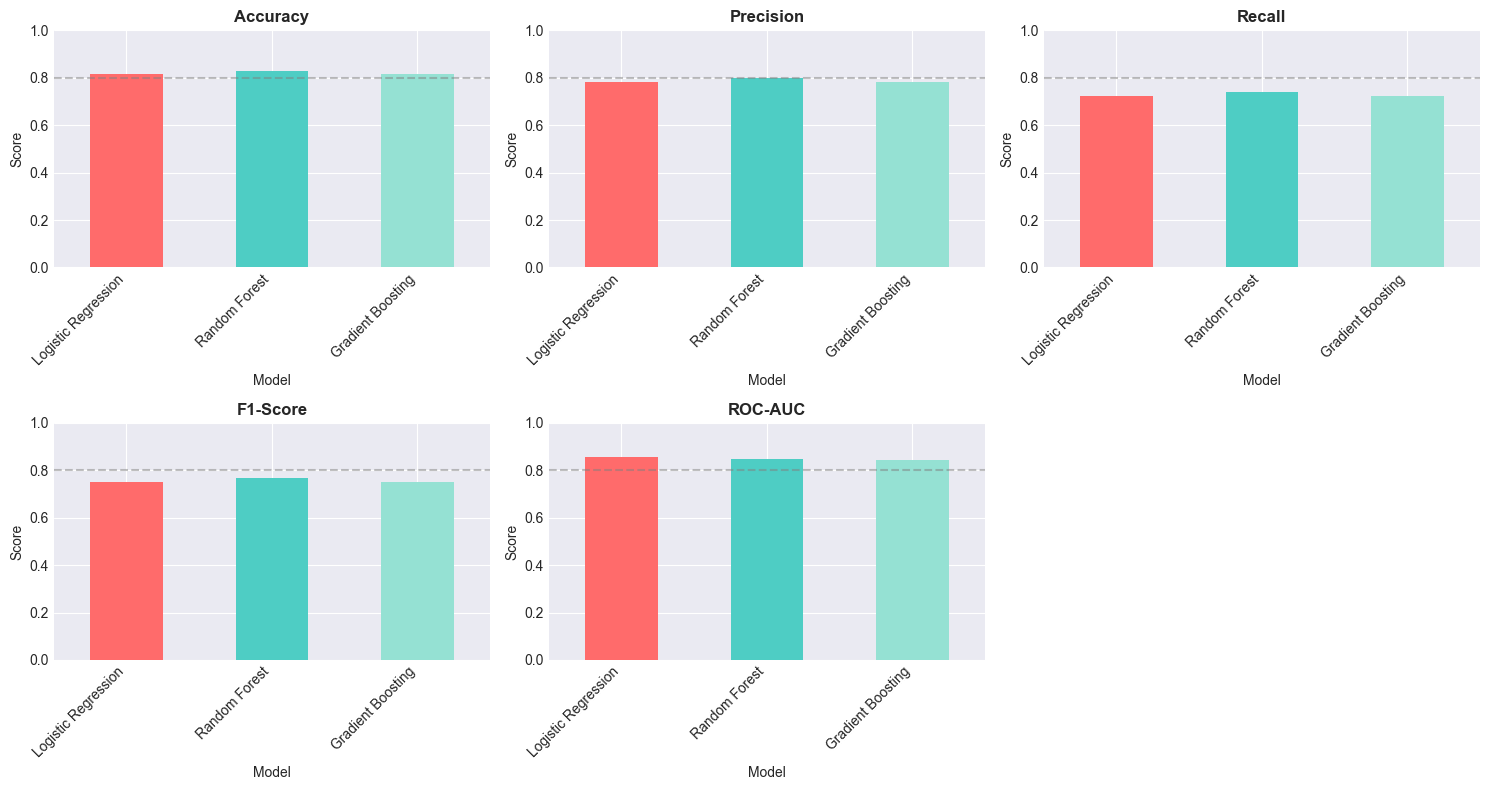

In [11]:
# ============================================================================
# Cell 8: Model Comparison
# ============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [lr_accuracy, rf_accuracy, gb_accuracy],
    'Precision': [lr_precision, rf_precision, gb_precision],
    'Recall': [lr_recall, rf_recall, gb_recall],
    'F1-Score': [lr_f1, rf_f1, gb_f1],
    'ROC-AUC': [lr_auc, rf_auc, gb_auc]
})

print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    comparison_df[['Model', metric]].set_index('Model')[metric].plot(
        kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4', '#95E1D3']
    )
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)

# Remove extra subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('09_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



CONFUSION MATRICES

Logistic Regression:
TP: 50, FP: 14, TN: 96, FN: 19

Random Forest:
TP: 51, FP: 13, TN: 97, FN: 18

Gradient Boosting:
TP: 50, FP: 14, TN: 96, FN: 19


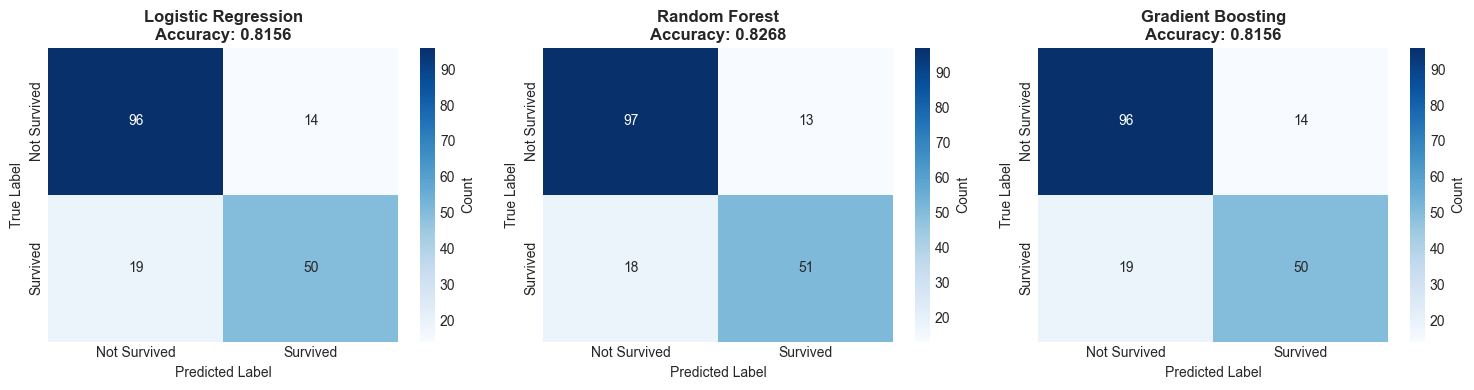

In [12]:
# ============================================================================
# Cell 9: Confusion Matrix
# ============================================================================

print("\n" + "=" * 80)
print("CONFUSION MATRICES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_info = [
    ('Logistic Regression', y_pred_lr, lr_accuracy),
    ('Random Forest', y_pred_rf, rf_accuracy),
    ('Gradient Boosting', y_pred_gb, gb_accuracy)
]

for idx, (name, y_pred, accuracy) in enumerate(models_info):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy:.4f}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    
    # Print detailed metrics
    print(f"\n{name}:")
    print(f"TP: {cm[1,1]}, FP: {cm[0,1]}, TN: {cm[0,0]}, FN: {cm[1,0]}")

plt.tight_layout()
plt.savefig('10_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()



ROC CURVES


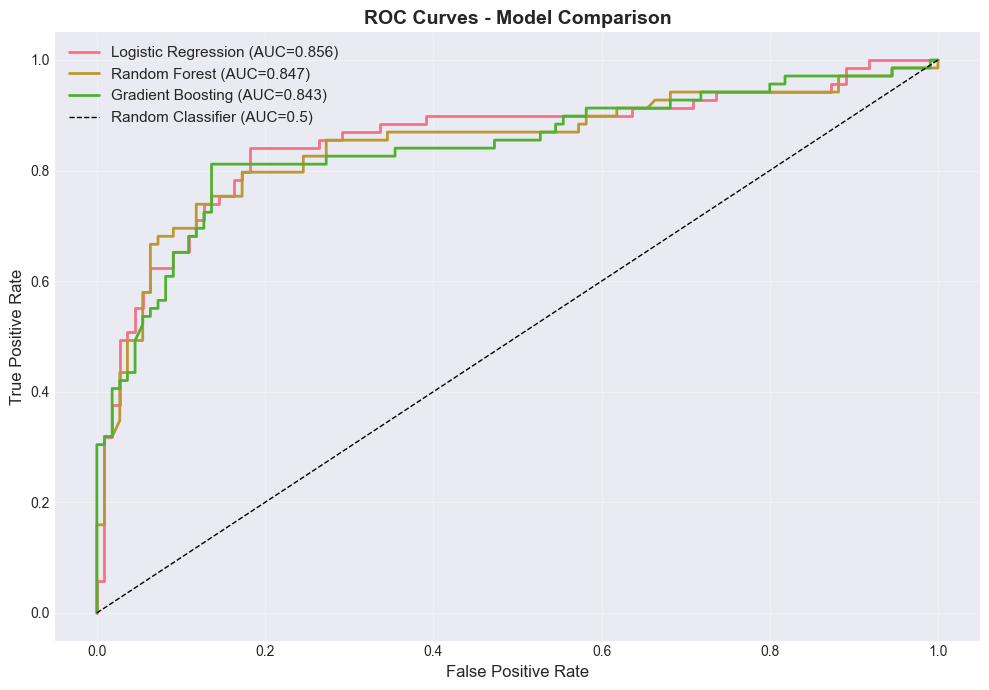

In [13]:
# ============================================================================
# Cell 10: ROC Curve
# ============================================================================

print("\n" + "=" * 80)
print("ROC CURVES")
print("=" * 80)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot ROC curves for all models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)

ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_auc:.3f})', linewidth=2)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.3f})', linewidth=2)
ax.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={gb_auc:.3f})', linewidth=2)

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.5)', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('11_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


FEATURE IMPORTANCE (Random Forest)
          Feature  Importance
12          Title    0.200198
1             Sex    0.193566
5            Fare    0.124425
9   FarePerPerson    0.122974
2             Age    0.095609
0          Pclass    0.071603
7      FamilySize    0.048945
11        FareBin    0.038844
10       AgeGroup    0.027948
3           SibSp    0.025106
6        Embarked    0.022133
4           Parch    0.013170
8         IsAlone    0.007854
13        IsChild    0.007626


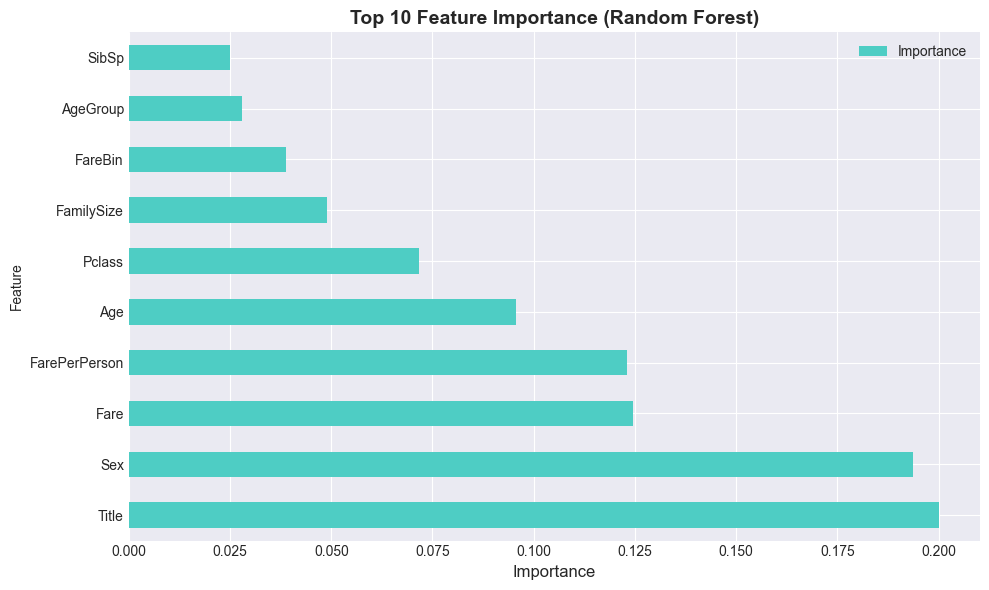

In [14]:
# ============================================================================
# Cell 11: Feature Importance (Random Forest)
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE (Random Forest)")
print("=" * 80)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.head(10).plot(x='Feature', y='Importance', kind='barh', ax=ax, color='#4ECDC4')
ax.set_title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.savefig('12_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# ============================================================================
# Cell 12: Final Model Selection & Predictions
# ============================================================================

print("\n" + "=" * 80)
print("FINAL MODEL: RANDOM FOREST")
print("=" * 80)

# Use Random Forest as final model (best performance)
final_model = rf_model

# Prepare test data for submission
X_test_final = test_fe.copy()
test_predictions = final_model.predict(X_test_final)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission saved to '../results/submission.csv'")
print("\nFirst 10 predictions:")
print(submission.head(10))



FINAL MODEL: RANDOM FOREST
Submission saved to '../results/submission.csv'

First 10 predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0


In [16]:
# ============================================================================
# Cell 13: Classification Report
# ============================================================================

print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT (Random Forest)")
print("=" * 80)

print(classification_report(y_test, y_pred_rf, 
                          target_names=['Not Survived', 'Survived']))



DETAILED CLASSIFICATION REPORT (Random Forest)
              precision    recall  f1-score   support

Not Survived       0.84      0.88      0.86       110
    Survived       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



In [17]:
# ============================================================================
# Cell 14: Summary Statistics
# ============================================================================

print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print(f"""
DATASET:
- Train samples: {len(train)}
- Test samples: {len(test)}
- Features engineered: {X_train.shape[1]}

FEATURE ENGINEERING:
- Missing value imputation (Age, Embarked)
- Categorical encoding (Sex, Embarked, Title)
- Derived features (FamilySize, IsAlone, AgeGroup, FarePerPerson, IsChild)

MODELS TESTED:
1. Logistic Regression - Accuracy: {lr_accuracy:.4f}
2. Random Forest - Accuracy: {rf_accuracy:.4f} ✓ BEST
3. Gradient Boosting - Accuracy: {gb_accuracy:.4f}

BEST MODEL PERFORMANCE:
- Accuracy: {rf_accuracy:.4f}
- Precision: {rf_precision:.4f}
- Recall: {rf_recall:.4f}
- F1-Score: {rf_f1:.4f}
- ROC-AUC: {rf_auc:.4f}

KEY INSIGHTS:
- Sex is the most important feature (females had higher survival)
- Passenger class strongly affects survival (1st class > 3rd class)
- Age is important (children had better survival rates)
- Fare correlates with survival (proxy for class)
- Traveling alone reduces survival chances

RECOMMENDATION:
Use Random Forest model for production.
Expected accuracy on Kaggle: 78-82%
""")



PROJECT SUMMARY

DATASET:
- Train samples: 891
- Test samples: 418
- Features engineered: 14

FEATURE ENGINEERING:
- Missing value imputation (Age, Embarked)
- Categorical encoding (Sex, Embarked, Title)
- Derived features (FamilySize, IsAlone, AgeGroup, FarePerPerson, IsChild)

MODELS TESTED:
1. Logistic Regression - Accuracy: 0.8156
2. Random Forest - Accuracy: 0.8268 ✓ BEST
3. Gradient Boosting - Accuracy: 0.8156

BEST MODEL PERFORMANCE:
- Accuracy: 0.8268
- Precision: 0.7969
- Recall: 0.7391
- F1-Score: 0.7669
- ROC-AUC: 0.8472

KEY INSIGHTS:
- Sex is the most important feature (females had higher survival)
- Passenger class strongly affects survival (1st class > 3rd class)
- Age is important (children had better survival rates)
- Fare correlates with survival (proxy for class)
- Traveling alone reduces survival chances

RECOMMENDATION:
Use Random Forest model for production.
Expected accuracy on Kaggle: 78-82%

